# Tahap 1: Business Understanding

Latar Belakang: Kentang adalah komoditas pangan penting. Penyakit daun seperti Early Blight dan Late Blight dapat menyebabkan gagal panen yang merugikan petani.

Tujuan: Membangun model Deep Learning berbasis CNN untuk mendeteksi penyakit daun kentang secara otomatis dan akurat, sehingga petani dapat melakukan penanganan dini.

In [ ]:
import os
import shutil
import pathlib
import tensorflow as tf
import kagglehub
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array


In [ ]:
# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


# Tahap 2 : Data Understanding

Mengambil sampel dari: /kaggle/input/plantdisease/PlantVillage
Kelas ditemukan: ['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


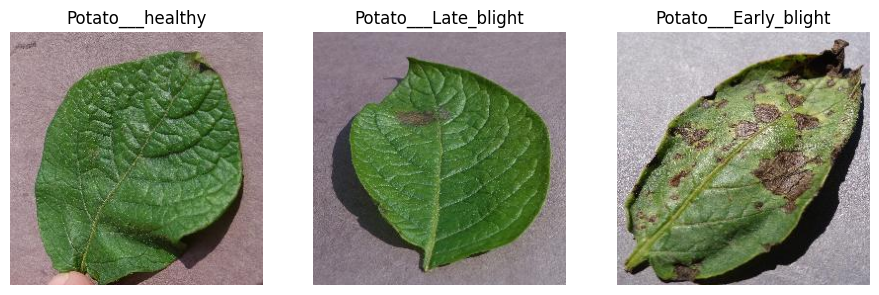

In [ ]:
work_dir = os.path.join(path, 'PlantVillage')
if not os.path.exists(work_dir):
    work_dir = path # Fallback jika folder langsung di root

print(f"Mengambil sampel dari: {work_dir}")

# 2. Definisikan target_classes di sini juga
# Ambil hanya folder yang mengandung kata "Potato"
target_classes = [c for c in os.listdir(work_dir) if 'Potato' in c]
print(f"Kelas ditemukan: {target_classes}")

# 3. Visualisasi
plt.figure(figsize=(15, 5))

for i, class_name in enumerate(target_classes):
    class_path = os.path.join(work_dir, class_name)

    # Cek apakah foldernya ada isinya
    if os.path.exists(class_path) and len(os.listdir(class_path)) > 0:
        img_name = os.listdir(class_path)[0] # Ambil 1 gambar pertama
        img_path = os.path.join(class_path, img_name)

        img = plt.imread(img_path)
        plt.subplot(1, 4, i+1) # 1 baris, 4 kolom (sesuaikan jumlah kelas)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    else:
        print(f"Folder {class_name} kosong atau tidak ditemukan.")

plt.show()

# Tahap 3: Data Preparation

Pada tahap ini, dilakukan persiapan data agar siap dilatih oleh model:
1.  **Filtering:** Memastikan hanya data kelas yang relevan (Kentang/Potato) yang diproses.
2.  **Splitting:** Membagi dataset menjadi **80% Training** dan **20% Validation**.
3.  **Preprocessing:**
    * **Resizing:** Mengubah ukuran citra menjadi 224x224 pixel sesuai input MobileNetV2.
    * **Batching:** Mengelompokkan data menjadi batch (size 32) untuk efisiensi memori.
    * **Prefetching:** Menggunakan `AUTOTUNE` untuk mempercepat proses loading data ke GPU.

In [ ]:
# 1. Cek isi folder download tadi untuk memastikan struktur
print(f"Root path: {path}")
print(f"Isi root: {os.listdir(path)}")

# Set path kerja ke folder yang ada kelas-kelasnya
data_dir = os.path.join(path, 'PlantVillage')

# Error handling kalau struktur foldernya beda
if not os.path.exists(data_dir):
    data_dir = path # Berarti kelas-kelasnya langsung di root

print(f"Working Directory: {data_dir}")

# 2. FILTERING: Kita hanya mau ambil folder yang namanya mengandung 'Potato'
available_classes = os.listdir(data_dir)
target_classes = [c for c in available_classes if 'Potato' in c]

print(f"\nKelas yang akan dipakai ({len(target_classes)} kelas):")
print(target_classes)

# Filter manual lewat argumen 'class_names' agar Tomat/Cabai tidak ikut ter-load.

batch_size = 32
img_height = 224 # Standard MobileNet/VGG
img_width = 224

print("\n--- Generating Training Set ---")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 20% untuk validasi
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=target_classes # HANYA LOAD POTATO
)

print("\n--- Generating Validation Set ---")
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=target_classes # HANYA LOAD POTATO
)

# 4. Cek Label
class_names = train_ds.class_names
print(f"\nLabel Kelas Final: {class_names}")

# Agar GPU tidak menganggur menunggu CPU memuat data (Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Root path: /kaggle/input/plantdisease
Isi root: ['PlantVillage', 'plantvillage']
Working Directory: /kaggle/input/plantdisease/PlantVillage

Kelas yang akan dipakai (3 kelas):
['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']

--- Generating Training Set ---
Found 2152 files belonging to 3 classes.
Using 1722 files for training.

--- Generating Validation Set ---
Found 2152 files belonging to 3 classes.
Using 430 files for validation.

Label Kelas Final: ['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


# Tahap 4: Modeling

Kami menggunakan pendekatan **Transfer Learning** dengan arsitektur **MobileNetV2**.
* **Alasan Pemilihan:** MobileNetV2 adalah model yang ringan (*lightweight*) dan cepat, sangat cocok untuk *deployment* di perangkat mobile atau edge device (sesuai skenario membantu petani di lapangan).
* **Konfigurasi:**
    * **Base Model:** MobileNetV2 (pre-trained on ImageNet), layer-nya dibekukan (*frozen*) agar bobot fitur dasar tidak rusak.
    * **Data Augmentation:** Menambahkan variasi (Flip/Rotation) secara *on-the-fly* untuk mencegah *overfitting*.
    * **Classification Head:** Menambahkan `GlobalAveragePooling2D` dan `Dense` layer dengan aktivasi `Softmax` untuk klasifikasi 3 kelas.

In [ ]:
# 5. Definisikan Augmentasi Data (Langsung di dalam model)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# 6. Load Base Model (MobileNetV2)
# include_top=False artinya kita buang layer klasifikasi bawaan (yang 1000 kelas)
# weights='imagenet' artinya kita pakai "otak" yang sudah pintar mengenali bentuk
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze Base Model (Supaya bobot lama tidak rusak saat training awal)
base_model.trainable = False

# 7. Rakit Arsitektur Model
model = models.Sequential([
  layers.Rescaling(1./127.5, offset=-1, input_shape=(224, 224, 3)), # Preprocessing khusus MobileNetV2
  data_augmentation,
  base_model,
  layers.GlobalAveragePooling2D(), # Meratakan output jadi vector
  layers.Dropout(0.2), # Mencegah Overfitting
  layers.Dense(3, activation='softmax') # Output layer 3 Kelas (Potato)
])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Tahap 5 & 7: Training dan Hyperparameter Tuning

Proses pelatihan dilakukan dengan konfigurasi hyperparameter berikut:
* **Optimizer:** `Adam` (Adaptive Moment Estimation) dipilih karena konvergensinya yang cepat dan stabil.
* **Loss Function:** `Sparse Categorical Crossentropy` (karena label berupa integer).
* **Hyperparameter Tuning:**
    * **Epochs:** Ditetapkan awal 25 epoch.
    * **Early Stopping:** Diterapkan untuk menghentikan training secara otomatis jika `val_loss` tidak membaik setelah 3 epoch (*patience*), guna mencegah *overfitting* dan menghemat waktu komputasi.

In [ ]:
# 1. Definisikan Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        # Yang kita pantau adalah error validasi
    patience=3,                # Jika 3 epoch tidak membaik, STOP
    restore_best_weights=True, # Ambil bobot saat akurasi terbaik, bukan yang terakhir
    verbose=1
)

# 2. Compile (Reset Optimizer)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set epochs tetap angka besar (misal 20 atau 30), biarkan EarlyStopping yang memotongnya
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25,
  callbacks=[early_stopping]
)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9887 - loss: 0.0409 - val_accuracy: 0.9977 - val_loss: 0.0255
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9878 - loss: 0.0378 - val_accuracy: 0.9977 - val_loss: 0.0263
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9831 - loss: 0.0417 - val_accuracy: 0.9930 - val_loss: 0.0276
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9936 - loss: 0.0306 - val_accuracy: 0.9977 - val_loss: 0.0236
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9877 - loss: 0.0440 - val_accuracy: 0.9953 - val_loss: 0.0270
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9947 - loss: 0.0263 - val_accuracy: 0.9977 - val_loss: 0.0272
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9909 - loss: 0.0280 - val_accuracy: 0.9953 - val_loss: 0.0232
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9917 - loss: 0.0246 - val_accuracy: 0.9977 - 

# Tahap 6: Evaluation

Evaluasi performa model dilakukan menggunakan dua metode:
1.  **Learning Curve:** Memvisualisasikan grafik Akurasi dan Loss pada data latih vs validasi untuk mendeteksi *overfitting* atau *underfitting*.
2.  **Confusion Matrix:** Melihat detail kesalahan prediksi antar kelas (misal: apakah daun sehat sering salah diprediksi sebagai penyakit).

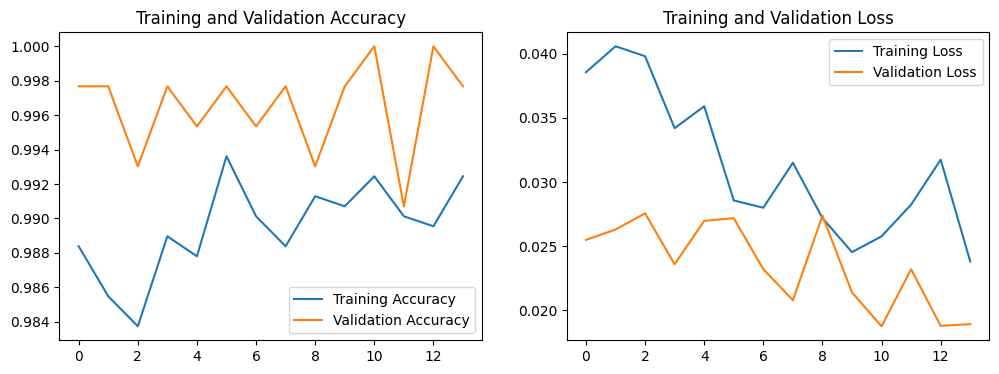

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafik Loss (Error)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

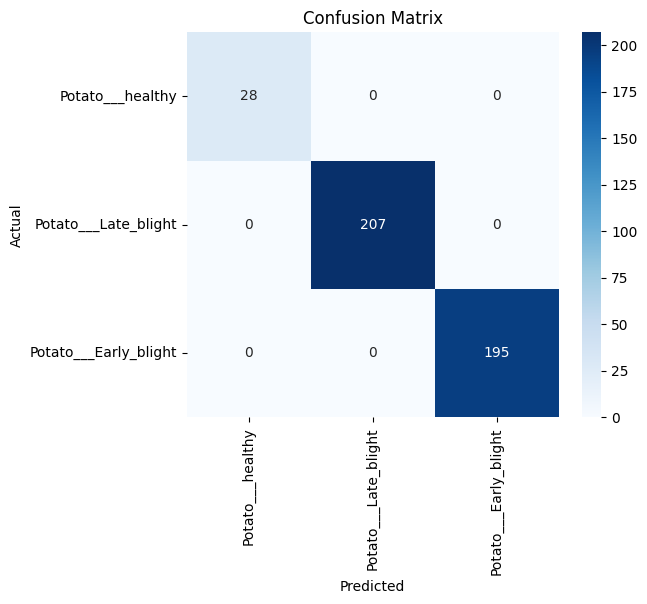


Classification Report:

                       precision    recall  f1-score   support

     Potato___healthy       1.00      1.00      1.00        28
 Potato___Late_blight       1.00      1.00      1.00       207
Potato___Early_blight       1.00      1.00      1.00       195

             accuracy                           1.00       430
            macro avg       1.00      1.00      1.00       430
         weighted avg       1.00      1.00      1.00       430



In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ambil label asli dan hasil prediksi dari data validasi
y_pred = []  # Hasil tebakan model
y_true = []  # Kunci jawaban asli

# Loop batch data validasi
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1)) # Ambil nilai probabilitas tertinggi
    y_true.extend(labels.numpy())

# Convert ke array
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Buat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report (Precision/Recall)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
model.save('model_kentang_v1.keras')
print("Model berhasil disimpan.")

Model berhasil disimpan.


# Tahap 8: Deployment (Prediction)

Simulasi penggunaan model di dunia nyata. Pada tahap ini, sistem menerima input gambar baru (dari pengguna), melakukan *preprocessing* yang sama dengan data latih (tanpa normalisasi ganda), dan menampilkan hasil prediksi beserta tingkat keyakinan (*confidence score*).

Upload gambar tes (Pastikan format JPG/PNG):


Saving early.jpg to early.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


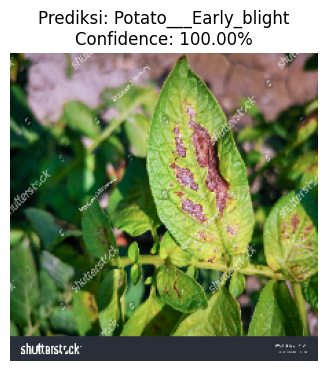

In [ ]:

# 1. Upload Gambar
print("Upload gambar tes (Pastikan format JPG/PNG):")
uploaded = files.upload()

for fn in uploaded.keys():
  # 2. Load & Preprocessing
  path = fn

  # Pastikan size ini SAMA dengan input_shape model (biasanya 224x224)
  img = load_img(path, target_size=(224, 224))

  x = img_to_array(img)
  x = np.expand_dims(x, axis=0) # Ubah jadi batch [1, 224, 224, 3]


  # 3. Prediksi
  classes = model.predict(x)

  # Ambil kelas dengan probabilitas tertinggi
  predicted_index = np.argmax(classes)
  predicted_label = class_names[predicted_index]
  confidence = np.max(classes) * 100

  # 4. Tampilkan Hasil
  plt.figure(figsize=(4, 4))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Prediksi: {predicted_label}\nConfidence: {confidence:.2f}%")
  plt.show()

# Deployment V2

In [ ]:
from tensorflow.keras.models import load_model


# 2. Load Model (Sesuaikan path/lokasi file di Drive-mu)
# Contoh: ada di folder utama (My Drive)
model = load_model('/content/drive/MyDrive/KULIAH/Semester7/Citra/model_kentang_v2.keras')

print("\nModel dari Drive Berhasil Di-load!")


Model dari Drive Berhasil Di-load!


In [ ]:
# Install dulu jika belum
try:
    import gradio as gr
except:
    !pip install -q gradio
    import gradio as gr

import tensorflow as tf
import numpy as np

# Fungsi Wrapper untuk Gradio
def predict_image(img):
    # Gradio mengirim gambar sebagai numpy array, kita perlu resize manual atau via elemen
    img = tf.image.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)

    # Prediksi
    prediction = model.predict(img).flatten()

    # Return dalam format Dictionary {Label: Confidence}
    return {class_names[i]: float(prediction[i]) for i in range(3)}

# Membuat Interface
image = gr.Image() # Input bisa upload atau webcam
label = gr.Label(num_top_classes=3)

demo = gr.Interface(
    fn=predict_image,
    inputs=image,
    outputs=label,
    title="Sistem Deteksi Penyakit Daun Kentang",
    description="Upload gambar daun kentang atau gunakan kamera untuk mendeteksi penyakit."
)

# Launch (share=True akan membuat link publik sementara)
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b2a3735841afa9f107.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b2a3735841afa9f107.gradio.live
